# Training Model

### Names:
- Idan Dunsky, 319070595
- Yaniv Kaveh Shtul, 206768004

# Imports and Installations

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import os
import yaml
import cv2

from google.colab import drive
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM
from google.colab import files
from torch.utils.data import Dataset
from tqdm import tqdm
%matplotlib inline

random.seed(42)

## Mount Google Drive

In [2]:
drive.mount('/content/drive')

# Define paths for train, validation, logging directories and models
BASE_PATH = '/content/drive/MyDrive/SoftwareEngDegree/Computer_Vision/Pet_and_People_Rec_Project/'
IMAGES_PATH = os.path.join(BASE_PATH, 'flickr30k_filtered_images')
YAML_PATH = os.path.join(BASE_PATH, 'conf_yaml.yaml')

# Train Directory
TRAIN_PATH = os.path.join(BASE_PATH, 'dataset/train/')
TRAIN_IMAGES_PATH = os.path.join(TRAIN_PATH, 'images/')
TRAIN_LABELS_PATH = os.path.join(TRAIN_PATH, 'labels/')

# Validation Directory
VAL_PATH = os.path.join(BASE_PATH, 'dataset/val/')
VAL_IMAGES_PATH = os.path.join(VAL_PATH, 'images/')
VAL_LABELS_PATH = os.path.join(VAL_PATH, 'labels/')

# Model with Augmentations Directory
AUG_PATH = os.path.join(BASE_PATH, 'augmented/')
AUG_LOG_PATH = os.path.join(AUG_PATH, 'log/')
AUG_MODEL_PATH = os.path.join(AUG_PATH, 'model_with_augmentations.pt')

# Model without Augmentations Directory
NO_AUG_PATH = os.path.join(BASE_PATH, 'not_augmented/')
NO_AUG_LOG_PATH = os.path.join(NO_AUG_PATH, 'log/')
NO_AUG_MODEL_PATH = os.path.join(NO_AUG_PATH, 'model_no_augmentations.pt')

# Create directories if they don't exist
os.makedirs(BASE_PATH, exist_ok=True)
os.makedirs(IMAGES_PATH, exist_ok=True)
os.makedirs(TRAIN_PATH, exist_ok=True)
os.makedirs(VAL_PATH, exist_ok=True)
os.makedirs(TRAIN_IMAGES_PATH, exist_ok=True)
os.makedirs(VAL_IMAGES_PATH, exist_ok=True)
os.makedirs(TRAIN_LABELS_PATH, exist_ok=True)
os.makedirs(VAL_LABELS_PATH, exist_ok=True)
os.makedirs(NO_AUG_PATH, exist_ok=True)
os.makedirs(AUG_PATH, exist_ok=True)
os.makedirs(AUG_LOG_PATH, exist_ok=True)
os.makedirs(NO_AUG_LOG_PATH, exist_ok=True)

Mounted at /content/drive


# Model Choice - YOLO8n
When choosing an object detection model, **YOLOv8 from Ultralytics** stands out for its speed, accuracy, ease of use, and versatility. Here’s why we chose YOLOv8 over other models:


### Benefits of YOLOv8

1. **Real-Time Performance**: YOLOv8 is extremely fast due to its one-stage architecture, making it ideal for real-time applications like autonomous driving and surveillance. It achieves low latency on both CPUs and GPUs.

2. **High Accuracy**: With improved backbone networks and detection heads, YOLOv8 provides excellent accuracy, especially for detecting objects of varying sizes. It also uses adaptive mechanisms for better bounding box predictions.

3. **Ease of Use and Versatility**: YOLOv8 supports object detection, segmentation, and classification in a unified framework. The Ultralytics Python package offers easy integration, training, and inference with minimal setup.

4. **Advanced Features**: Supports model compression, quantization, and transfer learning out of the box, optimizing for both edge devices and domain-specific applications.

5. **Strong Community Support**: Backed by an active community, YOLOv8 benefits from frequent updates, extensive documentation, and tutorials.

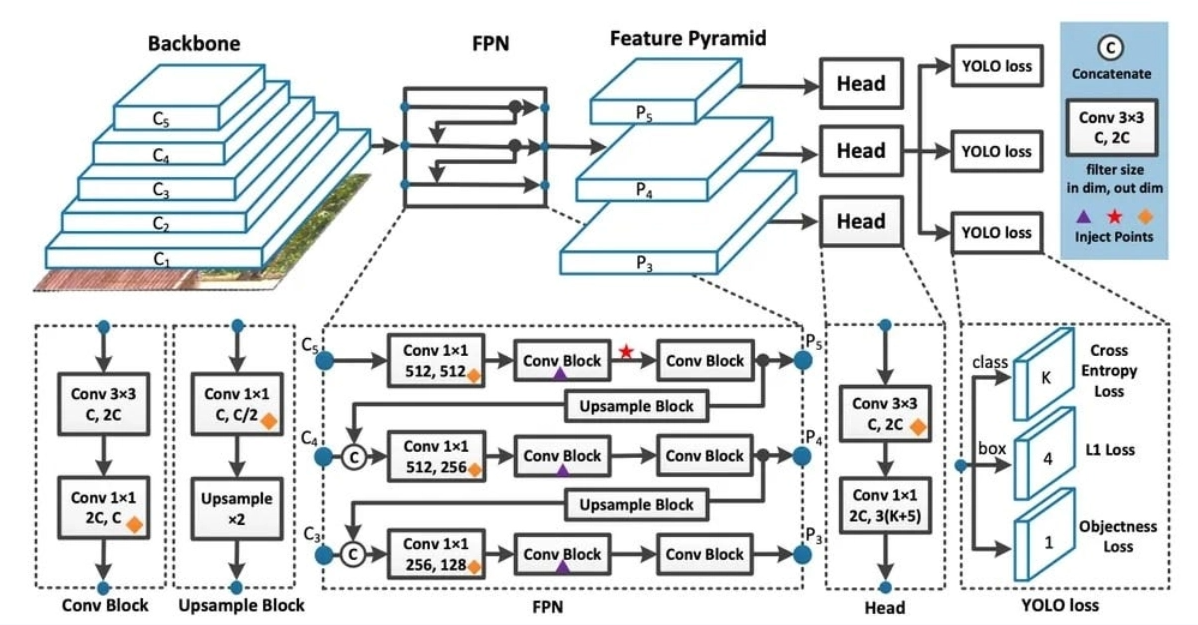

### Comparison with Other Models

- **Faster R-CNN**: High accuracy but too slow for real-time applications. YOLOv8 achieves similar accuracy with much faster speed.
- **RetinaNet**: Balances speed and accuracy but is slower than YOLOv8. YOLOv8’s improved architecture offers a better speed-accuracy trade-off.
- **EfficientDet**: Efficient for edge devices but lacks the versatility and latest optimizations found in YOLOv8.

### Conclusion

**YOLOv8** offers a superior balance of speed, accuracy, and usability, making it a top choice for real-time, versatile object detection tasks.


# Framework Choice - Ultralytics

The **Ultralytics framework** is chosen for implementing YOLOv8 due to the following key benefits:

### Benefits of the Ultralytics Framework

1. **Ease of Use**: Simple Python API allows quick integration, training, and inference with minimal code, suitable for both beginners and experts.

2. **Comprehensive Training and Deployment**: Supports easy training on custom datasets and exports to formats like ONNX and TensorRT, making deployment across platforms seamless.

3. **Pre-Trained Models and Transfer Learning**: Provides pre-trained models and facilitates easy fine-tuning, reducing time and resources for custom model development.

4. **Advanced Optimization Features**: Offers automated hyperparameter tuning, mixed-precision training, pruning, and quantization to optimize models for speed and accuracy.

5. **Strong Community and Documentation**: Active community, frequent updates, and extensive documentation provide excellent support and resources for development.

6. **Visualization and Monitoring**: Integrates with tools like TensorBoard and Weights & Biases for easy monitoring and debugging.

### Conclusion

The **Ultralytics framework** offers a user-friendly, flexible, and powerful environment, making it the ideal choice for leveraging YOLOv8 in high-performance computer vision tasks.


In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 873.6/873.6 kB 22.7 MB/s eta 0:00:00


In [4]:
import ultralytics
from ultralytics import YOLO

In [5]:
conf_yaml = {
    'path': BASE_PATH,
    'train': 'dataset/train/images',
    'val': 'dataset/val/images',
    'names': { 0: "person", 1: "pet" },
    'nc': 2,
    'albumentations': 0
}

with open(YAML_PATH, 'w') as file:
    yaml.dump(conf_yaml, file, default_flow_style=False)

# Model Training

We will start by loading a pre-trained YOLOv8 model using the Ultralytics framework to leverage transfer learning. This pre-trained model will be fine-tuned specifically to detect two classes: **`person`** and **`pet`**.

### Training Strategy:

1. **Load Pre-Trained YOLOv8**: Utilize a YOLOv8 model pre-trained on a large dataset (e.g., COCO) to benefit from its existing knowledge of general object features.

2. **Fine-Tune for Person and Pet Detection**: Train the model specifically on images containing `person` and `pet` classes, refining it to focus on these categories.

3. **No Data Augmentation**: Training will be done without augmentations to let the model learn directly from raw data and maintain baseline performance evaluation.

This approach allows us to quickly adapt YOLOv8 for our specific detection needs, ensuring a solid baseline without added complexity.

In [6]:
# Use cuda - run on GPU
device = torch.device("cuda")

model_params_no_augmentations = {
  'data': YAML_PATH,            # yaml path
  'optimizer': 'AdamW',         # weights optimizer
  'seed': 42,                   # random seed
  'epochs': 100,                # number of epochs
  'batch': 64,                  # batch size
  'augment': False,             # use augmentations (True/False)
  'auto_augment': None,
  'lr0': 3e-4,                  # initial learning rate (0.01)
  'lrf': 0.01,                  # final OneCycleLR learning rate (lr0 * lrf)
  'weight_decay': 0.0005,       # optimizer weight decay 5e-5, L2 regularization term
  'hsv_h': 0.0,                 # image HSV-Hue augmentation (fraction)
  'hsv_s': 0.0,                 # image HSV-Saturation augmentation (fraction)
  'hsv_v': 0.0,                 # image HSV-Value augmentation (fraction)
  'degrees': 0.0,               # image rotation (+/- deg)
  'scale': 0.0,                 # image scale (+/- gain)
  'perspective': 0.0,           # image perspective (+/- fraction), range 0-0.001
  'flipud': 0.0,                # image flip up-down (probability)
  'fliplr': 0.0,                # image flip left-right (probability)
  'mosaic': 0.0,                # image mosaic (probability)
  'mixup': 0.0,                 # image mixup (probability)
  'val': True,                  # validate/no validate
  'verbose': True,              # print results
  'project': NO_AUG_LOG_PATH,   # log directory
  'device': device
  }


In [7]:
# Load and train pretrained model
no_aug_model = YOLO("yolov8n.pt")
no_aug_results = no_aug_model.train(**model_params_no_augmentations)

100%|██████████| 6.25M/6.25M [00:00<00:00, 110MB/s]


engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/SoftwareEngDegree/Computer_Vision/Pet_and_People_Rec_Project/conf_yaml.yaml, epochs=100, time=None, patience=100, batch=64, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=/content/drive/MyDrive/SoftwareEngDegree/Computer_Vision/Pet_and_People_Rec_Project/not_augmented/log/, name=train, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, sav

100%|██████████| 755k/755k [00:00<00:00, 21.2MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/drive/MyDrive/SoftwareEngDegree/Computer_Vision/Pet_and_People_Rec_Project/dataset/train/labels.cache... 1278 images, 20 backgrounds, 0 corrupt: 100%|██████████| 1278/1278 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/SoftwareEngDegree/Computer_Vision/Pet_and_People_Rec_Project/dataset/val/labels.cache... 95 images, 0 backgrounds, 0 corrupt: 100%|██████████| 95/95 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/SoftwareEngDegree/Computer_Vision/Pet_and_People_Rec_Project/not_augmented/log/train/labels.jpg... 
optimizer: AdamW(lr=0.0003, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/SoftwareEngDegree/Computer_Vision/Pet_and_People_Rec_Project/not_augmented/log/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      8.06G     0.7187      2.598      1.101        134        640: 100%|██████████| 20/20 [00:43<00:00,  2.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.47s/it]

                   all         95        214     0.0062      0.886      0.289      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      8.13G     0.7633      1.334      1.135        140        640: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all         95        214          1     0.0268      0.448      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      8.26G     0.6935     0.9827      1.081        131        640: 100%|██████████| 20/20 [00:19<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

                   all         95        214      0.889      0.492      0.697      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      8.13G     0.6225     0.8468      1.028        149        640: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

                   all         95        214      0.783      0.677      0.782      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       8.1G     0.6008     0.7605      1.006        152        640: 100%|██████████| 20/20 [00:19<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]

                   all         95        214      0.827      0.689      0.773       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      8.18G     0.5666     0.7007     0.9824        142        640: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

                   all         95        214      0.852      0.746       0.86      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      8.15G     0.5454     0.6367      0.956        140        640: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all         95        214      0.848      0.777      0.856      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      8.17G     0.5099     0.5976      0.939        154        640: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all         95        214      0.832      0.747      0.856      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      8.15G     0.4836     0.5613     0.9192        163        640: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  2.00s/it]

                   all         95        214      0.802      0.792      0.868      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      8.26G     0.4698     0.5159     0.9128        122        640: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

                   all         95        214      0.792      0.771      0.839       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      8.15G     0.4497     0.5006     0.8998        120        640: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all         95        214      0.852      0.741      0.841      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      8.14G     0.4358     0.4797      0.894        124        640: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all         95        214      0.865      0.758      0.845       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      8.14G     0.4262     0.4495     0.8845        175        640: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all         95        214      0.845      0.785      0.842      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      8.18G     0.4054     0.4335     0.8738        150        640: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all         95        214      0.872      0.806      0.846      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      8.26G     0.4021     0.4198     0.8768        128        640: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

                   all         95        214      0.867      0.763       0.86      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      8.18G     0.3864     0.3905     0.8627        167        640: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all         95        214      0.886      0.742      0.863      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      8.05G     0.3843       0.39     0.8714        121        640: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all         95        214      0.914      0.745      0.861       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      8.05G     0.3688     0.3685     0.8599        157        640: 100%|██████████| 20/20 [00:20<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         95        214      0.882      0.782      0.876      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      8.14G      0.358     0.3588     0.8505        157        640: 100%|██████████| 20/20 [00:19<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all         95        214      0.907      0.738      0.847      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      8.15G     0.3465     0.3455     0.8475        159        640: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all         95        214      0.891      0.764      0.868      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100       8.1G      0.346     0.3342     0.8515        164        640: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]

                   all         95        214      0.799      0.787      0.828      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      8.14G     0.3355     0.3405     0.8449        137        640: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

                   all         95        214      0.873      0.766      0.861      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100       8.1G      0.333     0.3257     0.8424        138        640: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

                   all         95        214      0.821      0.812      0.866      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      8.18G     0.3301     0.3223      0.841        136        640: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

                   all         95        214      0.831      0.765      0.852      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      8.17G     0.3168     0.3091     0.8309        134        640: 100%|██████████| 20/20 [00:18<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

                   all         95        214      0.844      0.804      0.867      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      8.12G     0.3142     0.3126     0.8356        115        640: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

                   all         95        214      0.878      0.768      0.857      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      8.18G     0.3124     0.3064     0.8352        168        640: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

                   all         95        214      0.814      0.827      0.863      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      8.17G     0.3078     0.3004     0.8295        157        640: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

                   all         95        214      0.891      0.744      0.837       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      8.05G     0.3059     0.2936     0.8271        147        640: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]

                   all         95        214      0.859      0.774      0.842      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      8.04G     0.2928     0.2858     0.8258        153        640: 100%|██████████| 20/20 [00:19<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         95        214      0.875      0.792      0.868       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      8.14G     0.2919     0.2835     0.8242        187        640: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all         95        214      0.903      0.773      0.855      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      8.14G     0.2875     0.2742     0.8248        123        640: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all         95        214      0.863      0.783       0.86      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      8.04G     0.2776     0.2668     0.8152        159        640: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.11s/it]

                   all         95        214      0.835       0.74      0.868      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      8.13G     0.2791     0.2645     0.8209        121        640: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

                   all         95        214      0.878      0.822      0.897      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100       8.1G     0.2735      0.261     0.8174        159        640: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

                   all         95        214      0.877      0.817      0.888        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      8.12G     0.2761     0.2568     0.8151        125        640: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all         95        214       0.87      0.798      0.881      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      8.04G     0.2684     0.2501     0.8167        141        640: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

                   all         95        214      0.909      0.766      0.883      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      8.05G      0.269     0.2493     0.8139        148        640: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all         95        214      0.893      0.752      0.875      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      8.15G     0.2652     0.2463     0.8145        160        640: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

                   all         95        214      0.859      0.757      0.862      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      8.05G     0.2562     0.2463     0.8122        178        640: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]

                   all         95        214      0.872      0.774      0.871      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      8.04G     0.2544     0.2379     0.8078        130        640: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]

                   all         95        214      0.861      0.761      0.871      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      8.17G     0.2489     0.2349      0.809        182        640: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

                   all         95        214      0.834      0.828      0.871      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      8.05G      0.247     0.2326     0.8049        122        640: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

                   all         95        214      0.876      0.769       0.86      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100       8.1G     0.2423     0.2312     0.8063        180        640: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all         95        214      0.847      0.784      0.846      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      8.12G     0.2372     0.2279     0.8026        155        640: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

                   all         95        214      0.844      0.766      0.831      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      8.14G     0.2387     0.2233     0.8048        175        640: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

                   all         95        214      0.857      0.774      0.855      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      8.05G     0.2302     0.2185     0.8039        131        640: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all         95        214      0.831      0.784      0.859      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      8.26G       0.23     0.2165     0.8013        119        640: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]

                   all         95        214      0.839      0.783      0.857      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      8.17G     0.2235     0.2162     0.7956        127        640: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all         95        214      0.879      0.774      0.871      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      8.13G     0.2202     0.2104     0.7959        143        640: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

                   all         95        214      0.872      0.775      0.859      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      8.26G     0.2202     0.2098     0.7994        156        640: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

                   all         95        214      0.844      0.759      0.836      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      8.15G     0.2169      0.206     0.8009        154        640: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]

                   all         95        214      0.825      0.774      0.855      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      8.13G     0.2156     0.2058     0.7956        126        640: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

                   all         95        214       0.83      0.773      0.847      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      8.15G     0.2131     0.2044      0.802        149        640: 100%|██████████| 20/20 [00:18<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

                   all         95        214      0.902      0.748      0.862        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      8.04G     0.2112     0.2019      0.798        175        640: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]

                   all         95        214      0.873      0.753      0.835       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      8.13G     0.2114     0.2035     0.7943        160        640: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all         95        214      0.874      0.769      0.845      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      8.18G     0.2133     0.2018     0.8001        153        640: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

                   all         95        214       0.88      0.787      0.879      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      8.05G     0.2064     0.1981      0.796        132        640: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

                   all         95        214      0.857      0.796      0.877      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      8.13G     0.2054     0.1971     0.7929        122        640: 100%|██████████| 20/20 [00:19<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.17s/it]

                   all         95        214      0.869      0.771      0.865      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      8.05G     0.2032     0.1955     0.7944        117        640: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

                   all         95        214      0.842      0.805      0.853      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      8.05G     0.2049     0.1927      0.793        154        640: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

                   all         95        214      0.813      0.855      0.877      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      8.17G     0.2006     0.1928     0.7944        141        640: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all         95        214      0.891      0.773      0.874      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      8.13G     0.1986     0.1876     0.7938        153        640: 100%|██████████| 20/20 [00:20<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]

                   all         95        214      0.874      0.779      0.862      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      8.05G      0.192      0.184     0.7908        149        640: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all         95        214      0.869      0.769      0.852        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      8.13G      0.186     0.1792     0.7905        159        640: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

                   all         95        214      0.846      0.806      0.871      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100       8.1G     0.1846     0.1805     0.7878        154        640: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

                   all         95        214      0.909      0.773      0.868      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100       8.1G     0.1854     0.1793     0.7942        164        640: 100%|██████████| 20/20 [00:20<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

                   all         95        214       0.89        0.8      0.872      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100       8.1G     0.1852     0.1781     0.7891        162        640: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

                   all         95        214      0.849      0.815      0.879      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100       8.1G     0.1823     0.1775     0.7888        159        640: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all         95        214      0.919      0.778      0.886      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      8.04G     0.1784     0.1748      0.789        134        640: 100%|██████████| 20/20 [00:19<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]

                   all         95        214      0.879      0.795      0.881      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      8.12G     0.1808     0.1776     0.7915        148        640: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

                   all         95        214      0.911      0.774      0.885      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      8.17G     0.1793      0.175      0.792        135        640: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

                   all         95        214      0.896      0.776      0.878      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      8.12G      0.179      0.175     0.7958        154        640: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

                   all         95        214      0.896      0.803      0.896      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      8.17G     0.1751     0.1703     0.7862        144        640: 100%|██████████| 20/20 [00:20<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

                   all         95        214      0.916       0.79      0.893      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      8.14G     0.1735     0.1718     0.7904        139        640: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         95        214      0.912      0.751      0.876       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      8.18G     0.1673     0.1661     0.7875        151        640: 100%|██████████| 20/20 [00:18<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

                   all         95        214      0.883      0.772      0.878       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      8.14G     0.1696     0.1662     0.7885        130        640: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

                   all         95        214      0.909      0.781      0.885      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      8.26G     0.1648     0.1634     0.7811        171        640: 100%|██████████| 20/20 [00:20<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

                   all         95        214      0.898      0.773      0.878      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      8.05G     0.1625     0.1628     0.7846        170        640: 100%|██████████| 20/20 [00:18<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

                   all         95        214      0.883      0.782      0.887      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      8.12G     0.1636     0.1626     0.7828        139        640: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

                   all         95        214       0.88        0.8      0.885      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      8.18G     0.1618     0.1608     0.7826        129        640: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all         95        214      0.904      0.782      0.885      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      8.26G     0.1565     0.1585     0.7848        151        640: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

                   all         95        214      0.892      0.809      0.889      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100       8.1G     0.1566     0.1569     0.7859        112        640: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

                   all         95        214      0.913      0.768      0.887       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      8.06G     0.1554     0.1554      0.787        135        640: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]

                   all         95        214      0.888      0.785       0.88      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100       8.1G     0.1514     0.1519     0.7799        151        640: 100%|██████████| 20/20 [00:19<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

                   all         95        214      0.908       0.77      0.879      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      8.04G     0.1516     0.1527     0.7817        158        640: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

                   all         95        214      0.878      0.807      0.875       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      8.05G     0.1497     0.1517     0.7817        185        640: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

                   all         95        214      0.889        0.8      0.874      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      8.14G     0.1471     0.1491     0.7805        145        640: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.93s/it]

                   all         95        214      0.874      0.798      0.883      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100       8.1G     0.1479     0.1493     0.7805        142        640: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

                   all         95        214      0.893      0.804       0.89      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      8.12G     0.1455      0.149     0.7809        151        640: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

                   all         95        214      0.902      0.801      0.895      0.737


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100       8.1G     0.1437     0.1466     0.7878        176        640: 100%|██████████| 20/20 [00:27<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

                   all         95        214      0.882      0.799      0.885      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      8.17G     0.1434     0.1466     0.7782        138        640: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

                   all         95        214      0.927      0.781      0.885      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100       8.1G     0.1411     0.1459     0.7865        130        640: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

                   all         95        214      0.868      0.812      0.885      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      8.15G     0.1382      0.145     0.7801        153        640: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

                   all         95        214      0.866       0.81      0.883      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      8.05G     0.1392     0.1435     0.7776        132        640: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all         95        214      0.896      0.781      0.886      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100       8.1G     0.1363      0.142     0.7749        132        640: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

                   all         95        214       0.91       0.78      0.885      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100       8.1G     0.1376     0.1422     0.7777        146        640: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

                   all         95        214      0.922      0.771      0.887      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      8.17G     0.1337     0.1406     0.7758        143        640: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]

                   all         95        214      0.899      0.792      0.887      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      8.13G     0.1351     0.1412     0.7805        147        640: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

                   all         95        214      0.912      0.781      0.888      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      8.05G      0.133     0.1406     0.7788        135        640: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all         95        214      0.914      0.782      0.888      0.737



100 epochs completed in 0.637 hours.
Optimizer stripped from /content/drive/MyDrive/SoftwareEngDegree/Computer_Vision/Pet_and_People_Rec_Project/not_augmented/log/train/weights/last.pt, 6.3MB
Optimizer stripped from /content/drive/MyDrive/SoftwareEngDegree/Computer_Vision/Pet_and_People_Rec_Project/not_augmented/log/train/weights/best.pt, 6.3MB

Validating /content/drive/MyDrive/SoftwareEngDegree/Computer_Vision/Pet_and_People_Rec_Project/not_augmented/log/train/weights/best.pt...
Ultralytics YOLOv8.2.98 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


                   all         95        214      0.895      0.803      0.895      0.741
                person         60        153      0.872      0.803      0.872      0.693
                   pet         44         61      0.918      0.803      0.918       0.79
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /content/drive/MyDrive/SoftwareEngDegree/Computer_Vision/Pet_and_People_Rec_Project/not_augmented/log/train


### Save Model

In [8]:
# save not augmented model
no_aug_model.save(NO_AUG_MODEL_PATH)

The Ultralytics framework offers a convenient feature during training by automatically saving both the weights from the **last training epoch** and the **best-performing weights** based on validation metrics. This functionality ensures that we have access to the most optimal version of the model achieved during the training process.

### Loading the Best Model Weights:

To utilize the most effective version of our model, we will load the weights saved in `best.pt`. These weights correspond to the model's best performance, as determined by the evaluation metrics on the validation set. By loading `best.pt`, we ensure that the model is initialized with the most refined weights, which improves its accuracy and generalization for detecting the target classes: `person` and `pet`.

In [7]:
no_aug_model_best_weights = os.path.join(NO_AUG_LOG_PATH, 'train/weights/best.pt')
no_aug_model = YOLO(no_aug_model_best_weights)
no_aug_model.to(device)
no_aug_model.info()

Model summary: 225 layers, 3,011,238 parameters, 0 gradients, 8.2 GFLOPs


(225, 3011238, 0, 8.1952256)

## Statistics

The Ultralytics framework not only saves model weights but also automatically records comprehensive training statistics. This includes metrics such as **loss curves, precision, recall, mAP (mean Average Precision)**, and other performance indicators for each epoch.

### Simplified Model Analysis and Visualization:

These saved statistics facilitate easy plotting and analysis of various aspects of the model's performance. By accessing this data, we can efficiently visualize the training and validation trends, monitor overfitting or underfitting, and make informed decisions about model adjustments and improvements. This built-in logging and visualization support helps streamline the model development process, making it more efficient and insightful.

### Helper functions

In [9]:
def plot_results(results_path = None, column = None, title = None):
  if results_path is None:
    raise ValueError("Pass the path!")

  # Load the CSV file into a DataFrame
  df = pd.read_csv(results_path, sep=',', skipinitialspace=True)

  if column is None:
    columns = ['box_loss','cls_loss','dfl_loss']
  else:
    columns = [column]

  if title is not None:
    p_title = title

  # Plot training loss
  plt.figure(figsize=(15, 5))
  for i,column in enumerate(columns):
    plt.subplot(1,3,i+1)
    plt.plot(df['epoch'], df[f'train/{column}'], label=f'Training {column}', color='blue')
    plt.plot(df['epoch'], df[f'val/{column}'], label=f'Validation {column}', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    if title is None:
      p_title = f'Training and Validation {column} / epoch'

    plt.title(p_title)
    plt.legend()
    plt.grid(True)

  plt.show()

In [21]:
def graphs(log_file_path):
  file_path = os.path.join(log_file_path, 'train/results.png')
  graphs = cv2.imread(file_path)
  graphs = cv2.cvtColor(graphs, cv2.COLOR_BGR2RGB)
  plt.figure(figsize=(30,20))
  plt.imshow(graphs)
  plt.show()

### Graphs and Analysis

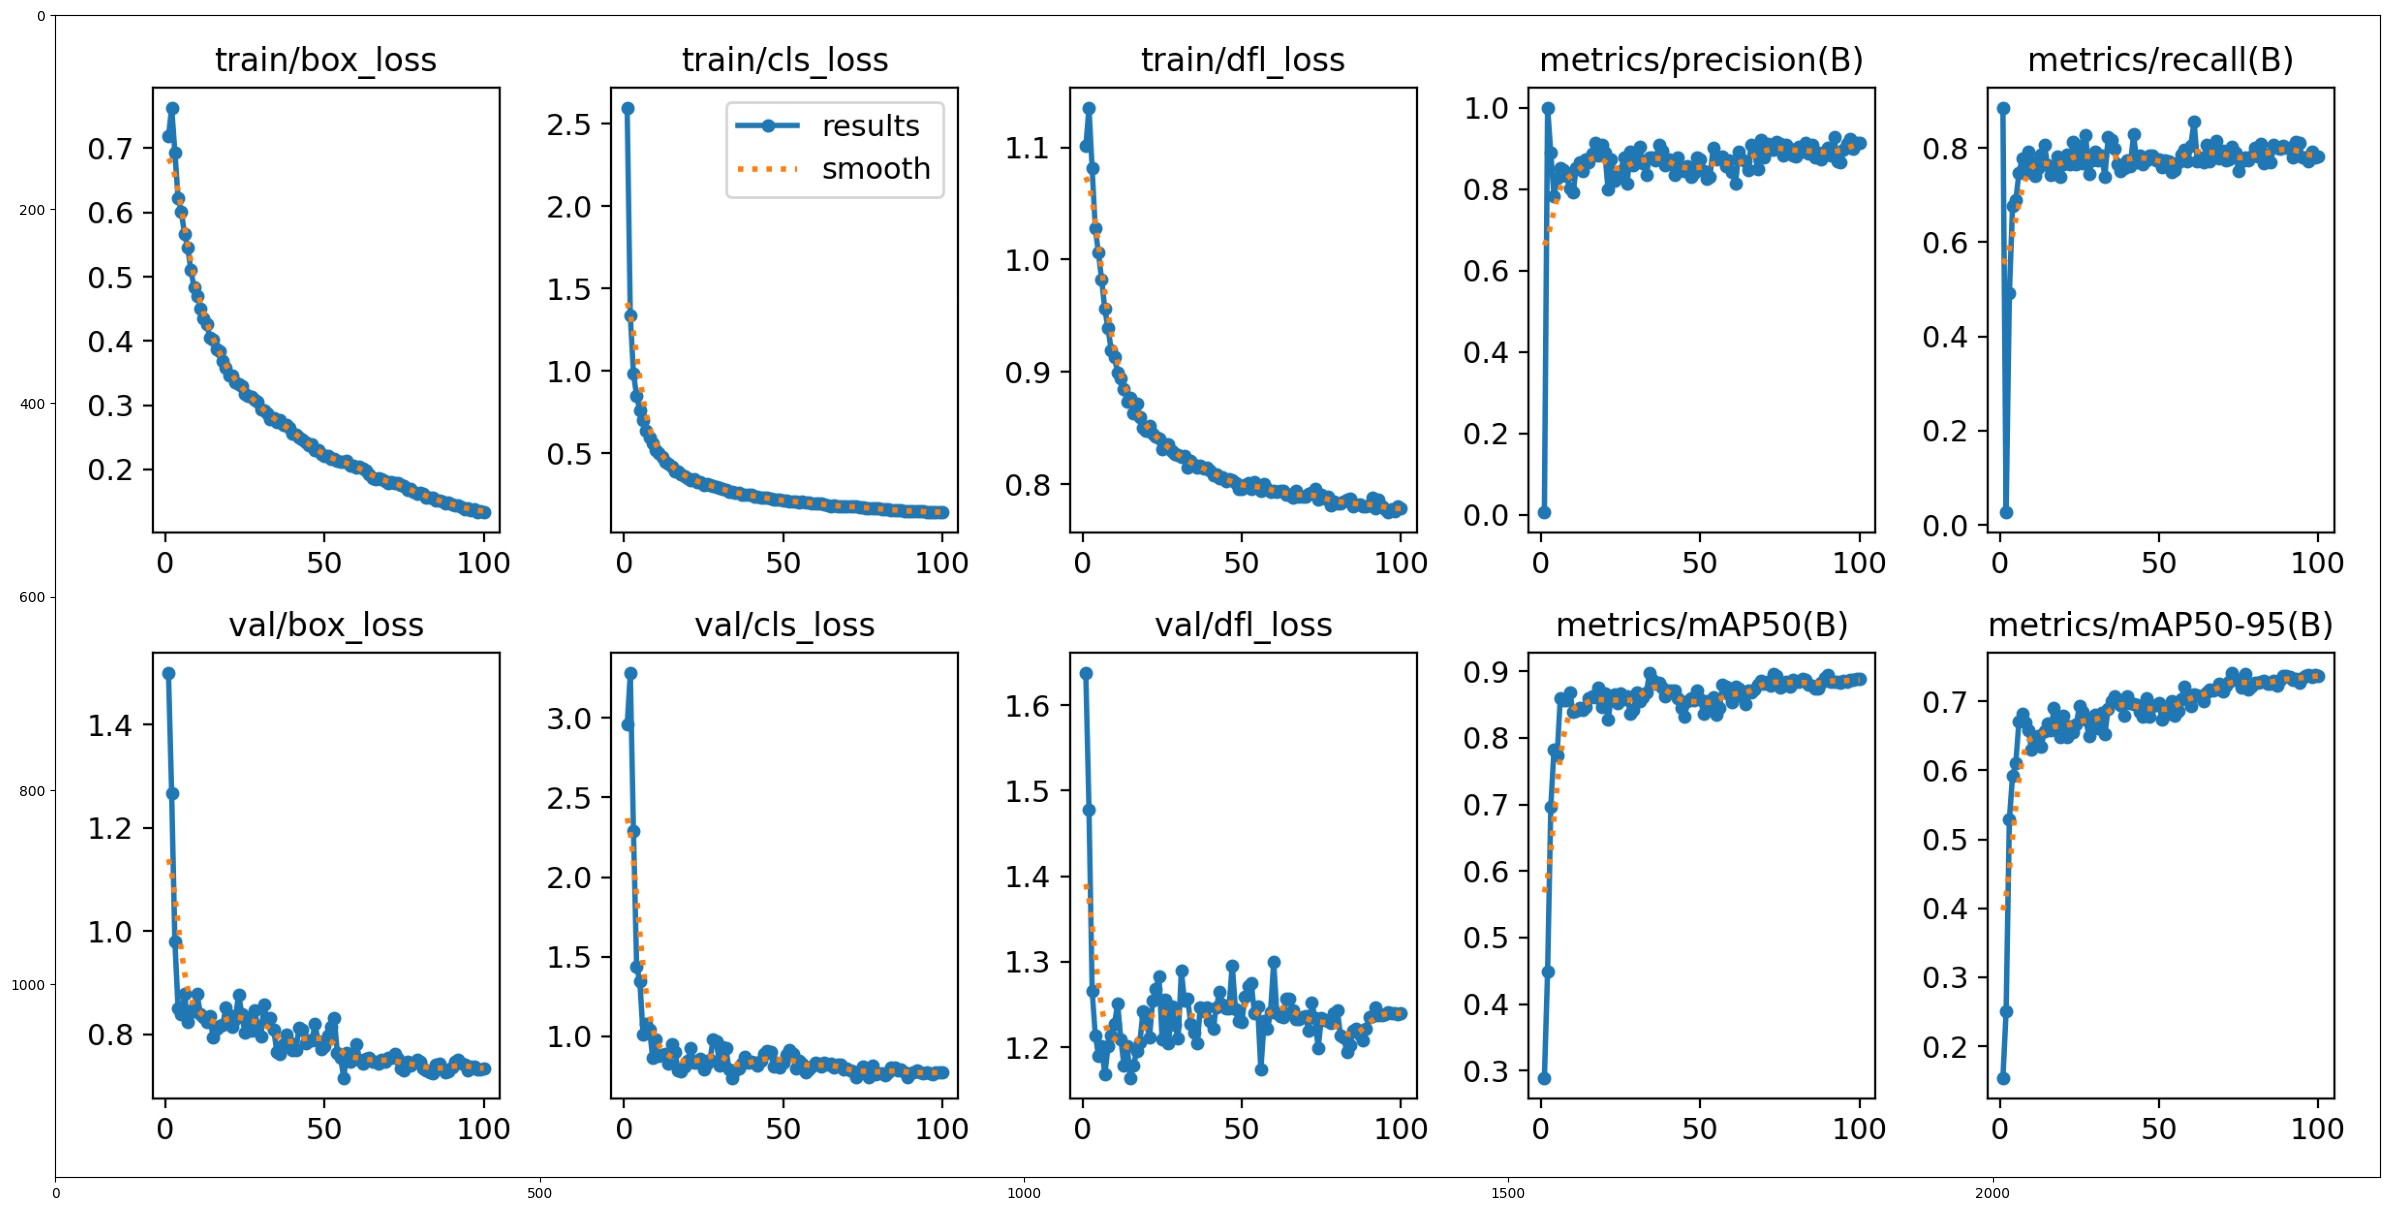

In [22]:
graphs(NO_AUG_LOG_PATH)

### Training Losses (Top Row):
1. **train/box_loss**:
   This plot shows a steady decrease in box loss during training, indicating that the model is improving its bounding box predictions over time.
   Both the original results (solid line) and smoothed results (dotted line) converge well after 100 epochs.

2. **train/cls_loss**:
   The classification loss also decreases significantly during training, demonstrating that the model is improving its classification of object classes.
   The loss starts high and decreases sharply before stabilizing.

3. **train/dfl_loss**:
   This might be the loss for distance focal loss (used in object detection models). The loss decreases and stabilizes, indicating that the model is effectively learning to focus on harder examples.

4. **metrics/precision(B)**:
   The precision increases over time and stabilizes above 0.9, suggesting that the model's predictions have high precision, meaning fewer false positives.

5. **metrics/recall(B)**:
   The recall quickly rises and stabilizes around 0.8, indicating that the model is correctly detecting a large portion of the true objects.

### Validation Losses (Bottom Row):
6. **val/box_loss**:
   The validation box loss decreases, similar to the training box loss, though it has more fluctuations, which could indicate overfitting or variations in the validation set.
   
7. **val/cls_loss**:
   The classification loss for validation follows a similar pattern to training loss but shows more instability. This could suggest the model is not generalizing as well.

8. **val/dfl_loss**:
   The validation distance focal loss fluctuates but decreases over time. The noise in this graph could indicate a need for further tuning or regularization.

9. **metrics/mAP50(B)**:
   The mean average precision at 50% IoU (Intersection over Union) stabilizes around 0.9, which is a strong performance indicator.

10. **metrics/mAP50-95(B)**:
    The mean average precision across a range of IoU thresholds (from 50% to 95%) also improves, stabilizing around 0.7, indicating solid performance in detecting objects at different scales and locations.

In summary:
- The model shows good convergence in both training and validation losses.
- Precision and recall metrics stabilize well, with precision slightly outperforming recall.
- There's some instability in validation losses, which could point to overfitting or dataset noise, but overall, the performance seems solid.

Let's conduct a comparative analysis of the training and validation loss graphs.

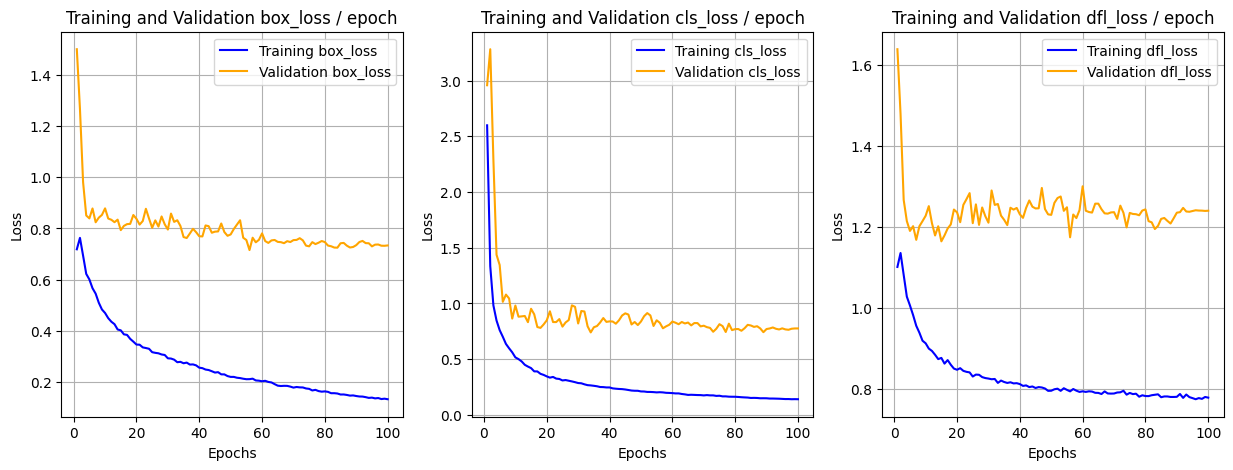

In [11]:
plot_results(results_path=no_aug_graphs_path)

This set of graphs presents a comparison of training and validation losses for box loss, classification loss, and distance focal loss.

### Analysis:

1. **Box Loss**: The training loss exhibits a steady decrease, whereas the validation loss levels off following a significant decline during the first 10 epochs. This discrepancy indicates potential overfitting, as the model performs better on the training data.

2. **Classification Loss**: The training curve shows a similar downward trend, while the validation loss remains stable with some fluctuations, reinforcing the likelihood of overfitting.

3. **Distance Focal Loss**: The training loss improves consistently; however, the validation loss shows variability, suggesting the presence of noise or a need for hyperparameter optimization.

### Summary:
The model demonstrates overfitting across all metrics, with validation losses stabilizing early. To address this issue, we will explore the addition of augmentations to mitigate overfitting and enhance model performance.

# Augmentations

Augmentations are techniques used to artificially expand your dataset by creating variations of existing images. They help improve model training by making the model more robust to different conditions and variations.

Here's a brief overview of the specific augmentations we will use and their benefits:

1. **HSV_H (Hue Shift)**: Adjusts the color tone, making the model more resilient to color variations.

2. **HSV_S (Saturation Shift)**: Changes color intensity, helping the model handle different lighting and color richness.

3. **HSV_V (Value Shift)**: Alters brightness, improving robustness to varying lighting conditions.

4. **Rotate 45 Degrees**: Adds orientation variability, helping the model recognize objects from different angles.

5. **Scale 0.2 Gain**: Changes object size, making the model more adaptable to different scales.

6. **Mixup (0.2 Probability)**: Blends two images to create new examples, reducing overfitting and improving generalization.

7. **Flip Vertically**: Flips the image along the horizontal axis, enhancing the model’s ability to handle vertical orientation changes.

8. **Flip Horizontally**: Flips the image along the vertical axis, improving robustness to horizontal orientation changes.

These augmentations help create a diverse training set, making the model more adaptable and improving its performance on unseen data.

In [12]:
device = torch.device("cuda")

model_params_augmentaions = {
  'data': YAML_PATH,        # yaml path
  'optimizer': 'AdamW',     # weights optimizer
  'seed': 42,               # random seed
  'epochs': 100,            # number of epochs
  'batch': 64,              # batch size
  'augment': True,          # use augmentations
  'lr0': 3e-4,              # initial learning rate (0.01)
  'lrf': 0.01,              # final OneCycleLR learning rate (lr0 * lrf)
  'weight_decay': 0.0005,   # optimizer weight decay 5e-5, L2 regularization term
  'hsv_h': 0.015,           # image HSV-Hue augmentation (fraction)
  'hsv_s': 0.7,             # image HSV-Saturation augmentation (fraction)
  'hsv_v': 0.4,             # image HSV-Value augmentation (fraction)
  'degrees': 45,            # image rotation (+/- deg)
  'scale': 0.2,             # image scale (+/- gain)
  'perspective': 0.0,       # image perspective (+/- fraction), range 0-0.001
  'flipud': 0.2,            # image flip up-down (probability)
  'fliplr': 0.2,            # image flip left-right (probability)
  'mosaic': 0.0,            # image mosaic (probability)
  'mixup': 0.2,             # image mixup (probability)
  'val': True,              # validate/no validate
  'verbose': True,          # print results
  'project': AUG_LOG_PATH,  # log directory
  'device': device          # cuda
  }

In [15]:
aug_model = YOLO("yolov8n.pt")
aug_results = aug_model.train(**model_params_augmentaions)

engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/SoftwareEngDegree/Computer_Vision/Pet_and_People_Rec_Project/conf_yaml.yaml, epochs=100, time=None, patience=100, batch=64, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=/content/drive/MyDrive/SoftwareEngDegree/Computer_Vision/Pet_and_People_Rec_Project/augmented/log/, name=train, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt

train: Scanning /content/drive/MyDrive/SoftwareEngDegree/Computer_Vision/Pet_and_People_Rec_Project/dataset/train/labels.cache... 1278 images, 20 backgrounds, 0 corrupt: 100%|██████████| 1278/1278 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/SoftwareEngDegree/Computer_Vision/Pet_and_People_Rec_Project/dataset/val/labels.cache... 95 images, 0 backgrounds, 0 corrupt: 100%|██████████| 95/95 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/SoftwareEngDegree/Computer_Vision/Pet_and_People_Rec_Project/augmented/log/train/labels.jpg... 
optimizer: AdamW(lr=0.0003, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/SoftwareEngDegree/Computer_Vision/Pet_and_People_Rec_Project/augmented/log/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      8.12G      1.927      3.079      2.274        201        640: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

                   all         95        214    0.00563      0.681     0.0344    0.00953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      8.14G      1.569      2.165      1.902        164        640: 100%|██████████| 20/20 [00:29<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.15s/it]

                   all         95        214    0.00652      0.571     0.0724     0.0198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      8.29G      1.499      1.779      1.842        162        640: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

                   all         95        214      0.298      0.226      0.201     0.0509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      8.19G      1.476      1.697      1.839        158        640: 100%|██████████| 20/20 [00:31<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

                   all         95        214      0.529      0.416       0.45      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      8.12G      1.479      1.603      1.839        162        640: 100%|██████████| 20/20 [00:31<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         95        214       0.72      0.657      0.707      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       8.2G       1.45      1.565      1.805        168        640: 100%|██████████| 20/20 [00:27<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]

                   all         95        214      0.741       0.63      0.746      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      8.16G      1.412      1.513      1.783        174        640: 100%|██████████| 20/20 [00:30<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all         95        214      0.829      0.689      0.807      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       8.2G      1.378      1.487      1.753        182        640: 100%|██████████| 20/20 [00:30<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

                   all         95        214      0.889      0.699      0.824       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      8.19G      1.356      1.454      1.731        195        640: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

                   all         95        214      0.823       0.74      0.832      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      8.29G      1.385      1.459      1.746        133        640: 100%|██████████| 20/20 [00:29<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

                   all         95        214      0.812      0.727      0.811       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      8.19G      1.367      1.416      1.737        153        640: 100%|██████████| 20/20 [00:31<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all         95        214      0.844      0.747       0.83      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      8.16G      1.357      1.404      1.736        150        640: 100%|██████████| 20/20 [00:29<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.10s/it]

                   all         95        214      0.794      0.737      0.804       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      8.16G      1.332      1.355      1.711        195        640: 100%|██████████| 20/20 [00:27<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

                   all         95        214      0.853      0.717      0.814      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100       8.2G       1.31      1.333      1.683        174        640: 100%|██████████| 20/20 [00:29<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all         95        214      0.881      0.738      0.837      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      8.28G      1.303      1.328      1.678        161        640: 100%|██████████| 20/20 [00:30<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all         95        214      0.763      0.731      0.779      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100       8.2G      1.291      1.285      1.671        225        640: 100%|██████████| 20/20 [00:26<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]

                   all         95        214      0.872      0.714      0.814      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      8.17G      1.293      1.274      1.668        129        640: 100%|██████████| 20/20 [00:30<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

                   all         95        214      0.891      0.712      0.848       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      8.12G      1.302      1.276      1.661        177        640: 100%|██████████| 20/20 [00:30<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

                   all         95        214      0.865      0.724       0.84      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      8.16G      1.268       1.25      1.642        182        640: 100%|██████████| 20/20 [00:27<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.08s/it]

                   all         95        214      0.718      0.677      0.767        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      8.17G      1.274      1.273      1.655        197        640: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

                   all         95        214       0.82      0.742      0.851       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      8.16G      1.216      1.207      1.603        193        640: 100%|██████████| 20/20 [00:30<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all         95        214      0.863      0.751      0.857      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      8.16G      1.236      1.209      1.609        158        640: 100%|██████████| 20/20 [00:26<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.27s/it]

                   all         95        214      0.811      0.767      0.832      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      8.12G      1.251      1.219      1.637        171        640: 100%|██████████| 20/20 [00:27<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

                   all         95        214      0.801      0.766      0.819      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      8.16G       1.21      1.181      1.595        157        640: 100%|██████████| 20/20 [00:29<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

                   all         95        214      0.866      0.704      0.838      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100       8.2G        1.2      1.177        1.6        165        640: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

                   all         95        214      0.787      0.787      0.814      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      8.14G      1.229      1.202      1.621        151        640: 100%|██████████| 20/20 [00:28<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

                   all         95        214      0.778      0.775      0.832      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100       8.2G      1.176      1.152      1.579        199        640: 100%|██████████| 20/20 [00:29<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]

                   all         95        214      0.833      0.743      0.829      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      8.19G       1.21      1.144      1.597        207        640: 100%|██████████| 20/20 [00:26<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]

                   all         95        214      0.815      0.761      0.832      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      8.07G       1.16      1.107       1.55        161        640: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all         95        214      0.878      0.751      0.854      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      8.15G      1.182      1.104      1.572        177        640: 100%|██████████| 20/20 [00:31<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

                   all         95        214      0.839      0.809       0.87      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      8.16G      1.194      1.121       1.58        209        640: 100%|██████████| 20/20 [00:27<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]

                   all         95        214      0.855      0.738      0.844      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      8.16G      1.166        1.1      1.549        169        640: 100%|██████████| 20/20 [00:29<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

                   all         95        214      0.858       0.82      0.871      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      8.14G      1.176      1.095      1.558        174        640: 100%|██████████| 20/20 [00:30<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

                   all         95        214      0.855      0.756      0.866      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      8.16G       1.15       1.06      1.539        151        640: 100%|██████████| 20/20 [00:27<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]

                   all         95        214      0.921      0.726      0.879      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      8.16G      1.159      1.087      1.546        196        640: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all         95        214      0.827        0.8      0.865      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      8.14G      1.157      1.078      1.535        144        640: 100%|██████████| 20/20 [00:31<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

                   all         95        214       0.84      0.793       0.86      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      8.07G      1.132      1.045      1.527        165        640: 100%|██████████| 20/20 [00:27<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

                   all         95        214      0.856      0.743      0.818      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      8.07G      1.161      1.089      1.544        179        640: 100%|██████████| 20/20 [00:30<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

                   all         95        214      0.836      0.762      0.844      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      8.17G      1.129      1.035      1.521        216        640: 100%|██████████| 20/20 [00:30<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]

                   all         95        214      0.809      0.815      0.847      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      8.16G      1.123      1.032      1.511        216        640: 100%|██████████| 20/20 [00:27<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all         95        214      0.872      0.764       0.86      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      8.16G      1.139      1.047      1.529        174        640: 100%|██████████| 20/20 [00:31<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

                   all         95        214      0.876      0.777      0.872      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      8.19G       1.09      1.004       1.49        209        640: 100%|██████████| 20/20 [00:28<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]

                   all         95        214      0.828       0.78      0.858       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      8.16G      1.097      1.007      1.505        167        640: 100%|██████████| 20/20 [00:27<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         95        214       0.84      0.749      0.843      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      8.15G      1.094      1.008      1.496        214        640: 100%|██████████| 20/20 [00:30<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all         95        214       0.84      0.775      0.856      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      8.16G      1.111     0.9756      1.502        166        640: 100%|██████████| 20/20 [00:28<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.17s/it]

                   all         95        214      0.846      0.748      0.845      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      8.15G      1.075      0.983      1.472        193        640: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

                   all         95        214      0.825      0.744      0.836      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      8.16G      1.101     0.9932      1.496        157        640: 100%|██████████| 20/20 [00:30<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

                   all         95        214      0.813      0.728      0.834      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      8.28G      1.087     0.9943      1.503        149        640: 100%|██████████| 20/20 [00:28<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]

                   all         95        214      0.833      0.753      0.862      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      8.19G      1.075     0.9566      1.468        156        640: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all         95        214      0.857      0.781      0.863      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      8.17G      1.076     0.9865      1.469        182        640: 100%|██████████| 20/20 [00:30<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

                   all         95        214      0.849      0.802      0.859       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      8.28G      1.067     0.9612      1.476        184        640: 100%|██████████| 20/20 [00:29<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]

                   all         95        214      0.919      0.738      0.863      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      8.19G      1.063     0.9755       1.47        185        640: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

                   all         95        214      0.841      0.795       0.87      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      8.14G      1.038     0.9345      1.449        172        640: 100%|██████████| 20/20 [00:31<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

                   all         95        214      0.884      0.749      0.868      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      8.19G      1.043     0.9241      1.451        160        640: 100%|██████████| 20/20 [00:30<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]

                   all         95        214      0.856      0.783      0.865      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      8.07G      1.039     0.9241      1.451        195        640: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all         95        214      0.875      0.744      0.844      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      8.16G      1.023     0.9347      1.444        195        640: 100%|██████████| 20/20 [00:30<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

                   all         95        214      0.799      0.803      0.854       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100       8.2G      1.031     0.9273      1.439        177        640: 100%|██████████| 20/20 [00:30<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.27s/it]

                   all         95        214      0.807      0.802      0.862      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      8.07G      1.014     0.9203       1.42        163        640: 100%|██████████| 20/20 [00:27<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

                   all         95        214       0.85      0.796      0.863      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      8.16G      1.004       0.89      1.415        155        640: 100%|██████████| 20/20 [00:29<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all         95        214      0.887      0.756      0.867      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      8.16G      1.011     0.8945      1.421        144        640: 100%|██████████| 20/20 [00:29<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]

                   all         95        214      0.867      0.764      0.865      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      8.07G     0.9846     0.8622      1.391        180        640: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

                   all         95        214      0.809      0.806      0.879      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       8.2G     0.9911     0.8822      1.409        162        640: 100%|██████████| 20/20 [00:30<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

                   all         95        214      0.879      0.763      0.863      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      8.15G      1.022      0.897      1.431        184        640: 100%|██████████| 20/20 [00:30<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all         95        214      0.875      0.774      0.866       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      8.16G      1.021     0.9028       1.43        181        640: 100%|██████████| 20/20 [00:26<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]

                   all         95        214      0.802        0.8      0.853      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      8.28G       1.01      0.891      1.425        180        640: 100%|██████████| 20/20 [00:28<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.53s/it]

                   all         95        214      0.828      0.813      0.866      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      8.12G      1.008     0.8845      1.424        176        640: 100%|██████████| 20/20 [00:32<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

                   all         95        214      0.822      0.808      0.861      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      8.14G      1.002     0.8446      1.403        206        640: 100%|██████████| 20/20 [00:27<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.36s/it]

                   all         95        214      0.844      0.781      0.863       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      8.12G     0.9996     0.8674      1.411        184        640: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         95        214      0.877      0.755      0.861      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      8.07G     0.9749     0.8489      1.393        200        640: 100%|██████████| 20/20 [00:29<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

                   all         95        214      0.877      0.766      0.858      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      8.12G     0.9901     0.8789      1.397        158        640: 100%|██████████| 20/20 [00:29<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.20s/it]

                   all         95        214       0.91      0.757      0.863      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      8.14G      1.003     0.8803      1.412        174        640: 100%|██████████| 20/20 [00:27<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]

                   all         95        214       0.88      0.761      0.864      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      8.19G      0.955     0.8445      1.378        165        640: 100%|██████████| 20/20 [00:28<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all         95        214      0.851        0.8      0.874       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      8.14G      0.944     0.8362       1.36        190        640: 100%|██████████| 20/20 [00:30<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.63s/it]

                   all         95        214      0.837      0.822      0.873      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      8.19G     0.9335     0.7984      1.355        184        640: 100%|██████████| 20/20 [00:26<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]

                   all         95        214       0.89      0.789      0.884      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      8.16G     0.9682     0.8424      1.389        164        640: 100%|██████████| 20/20 [00:29<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

                   all         95        214      0.889      0.763      0.879      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100       8.2G      0.964     0.8586      1.395        176        640: 100%|██████████| 20/20 [00:30<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

                   all         95        214       0.91      0.776      0.888      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      8.16G     0.9858     0.8272      1.389        169        640: 100%|██████████| 20/20 [00:27<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

                   all         95        214      0.869      0.802      0.884      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      8.28G     0.9568     0.8278      1.367        190        640: 100%|██████████| 20/20 [00:29<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

                   all         95        214      0.854      0.794      0.886      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      8.14G     0.9718     0.8621      1.393        221        640: 100%|██████████| 20/20 [00:29<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]

                   all         95        214      0.889      0.776      0.879      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      8.19G     0.9106     0.7879      1.337        186        640: 100%|██████████| 20/20 [00:26<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]

                   all         95        214      0.854      0.818      0.887      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100       8.2G     0.9399      0.804      1.348        150        640: 100%|██████████| 20/20 [00:29<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all         95        214      0.903       0.78      0.884      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      8.28G     0.9606     0.8347      1.371        169        640: 100%|██████████| 20/20 [00:30<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.15s/it]

                   all         95        214      0.877      0.784      0.879       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      8.16G     0.9298     0.7772      1.354        137        640: 100%|██████████| 20/20 [00:27<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all         95        214      0.833      0.809      0.874      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      8.18G     0.9255     0.7925      1.351        148        640: 100%|██████████| 20/20 [00:31<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

                   all         95        214      0.924      0.751      0.874       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      8.14G     0.9117     0.7982      1.328        194        640: 100%|██████████| 20/20 [00:30<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.10s/it]

                   all         95        214      0.873      0.777       0.88      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      8.12G     0.9263     0.7999       1.35        177        640: 100%|██████████| 20/20 [00:27<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

                   all         95        214      0.859      0.787      0.877      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      8.16G     0.9306     0.8101      1.358        198        640: 100%|██████████| 20/20 [00:31<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         95        214      0.883      0.806      0.881      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      8.16G     0.9014     0.7816      1.331        160        640: 100%|██████████| 20/20 [00:30<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.11s/it]

                   all         95        214      0.909      0.766      0.877      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      8.14G     0.9155     0.8064      1.346        165        640: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

                   all         95        214      0.901      0.763       0.88      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      8.15G      0.891     0.7612      1.319        168        640: 100%|██████████| 20/20 [00:28<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

                   all         95        214      0.851      0.802      0.881      0.674


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      8.14G     0.7194     0.5503      1.155        177        640: 100%|██████████| 20/20 [00:31<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

                   all         95        214       0.93       0.75      0.874      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      8.19G     0.7139      0.538      1.152        138        640: 100%|██████████| 20/20 [00:25<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.17s/it]

                   all         95        214      0.846      0.794      0.876      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      8.12G     0.7244     0.5344      1.172        130        640: 100%|██████████| 20/20 [00:24<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all         95        214      0.873      0.782       0.88      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      8.18G     0.7028      0.518      1.142        151        640: 100%|██████████| 20/20 [00:25<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]

                   all         95        214      0.924      0.746      0.885      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      8.08G     0.7003     0.5248      1.146        132        640: 100%|██████████| 20/20 [00:24<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

                   all         95        214      0.924      0.764      0.885      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      8.12G     0.7063     0.5192      1.142        132        640: 100%|██████████| 20/20 [00:26<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]

                   all         95        214      0.906      0.761      0.884      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      8.12G     0.7049      0.518      1.145        146        640: 100%|██████████| 20/20 [00:24<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all         95        214      0.907      0.756      0.885      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      8.19G     0.6895     0.5085      1.136        143        640: 100%|██████████| 20/20 [00:24<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

                   all         95        214      0.884      0.774      0.885      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      8.15G     0.7046     0.5191       1.15        145        640: 100%|██████████| 20/20 [00:24<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

                   all         95        214      0.851      0.792      0.882      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      8.07G     0.6962     0.5204      1.139        137        640: 100%|██████████| 20/20 [00:25<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]

                   all         95        214      0.849      0.799      0.882       0.67



100 epochs completed in 0.926 hours.
Optimizer stripped from /content/drive/MyDrive/SoftwareEngDegree/Computer_Vision/Pet_and_People_Rec_Project/augmented/log/train/weights/last.pt, 6.3MB
Optimizer stripped from /content/drive/MyDrive/SoftwareEngDegree/Computer_Vision/Pet_and_People_Rec_Project/augmented/log/train/weights/best.pt, 6.3MB

Validating /content/drive/MyDrive/SoftwareEngDegree/Computer_Vision/Pet_and_People_Rec_Project/augmented/log/train/weights/best.pt...
Ultralytics YOLOv8.2.98 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


                   all         95        214      0.802      0.818      0.872      0.681
                person         60        153      0.741      0.804      0.853      0.644
                   pet         44         61      0.864      0.832      0.891      0.719
Speed: 0.5ms preprocess, 6.9ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /content/drive/MyDrive/SoftwareEngDegree/Computer_Vision/Pet_and_People_Rec_Project/augmented/log/train


In [16]:
# save model
aug_model.save(AUG_MODEL_PATH)

## Loading the Best Model Weights:

In [13]:
aug_model_best_weights = os.path.join(AUG_LOG_PATH, 'train/weights/best.pt')
aug_model = YOLO(aug_model_best_weights)
aug_model.to(device)
aug_model.info()

Model summary: 225 layers, 3,011,238 parameters, 0 gradients, 8.2 GFLOPs


(225, 3011238, 0, 8.1952256)

## Statistics

In the same way that we approached the task with the non-augmented model, we will follow a similar methodology here. This will involve applying the same principles and techniques, allowing us to draw meaningful comparisons between the two models and assess the impact of augmentation on performance.

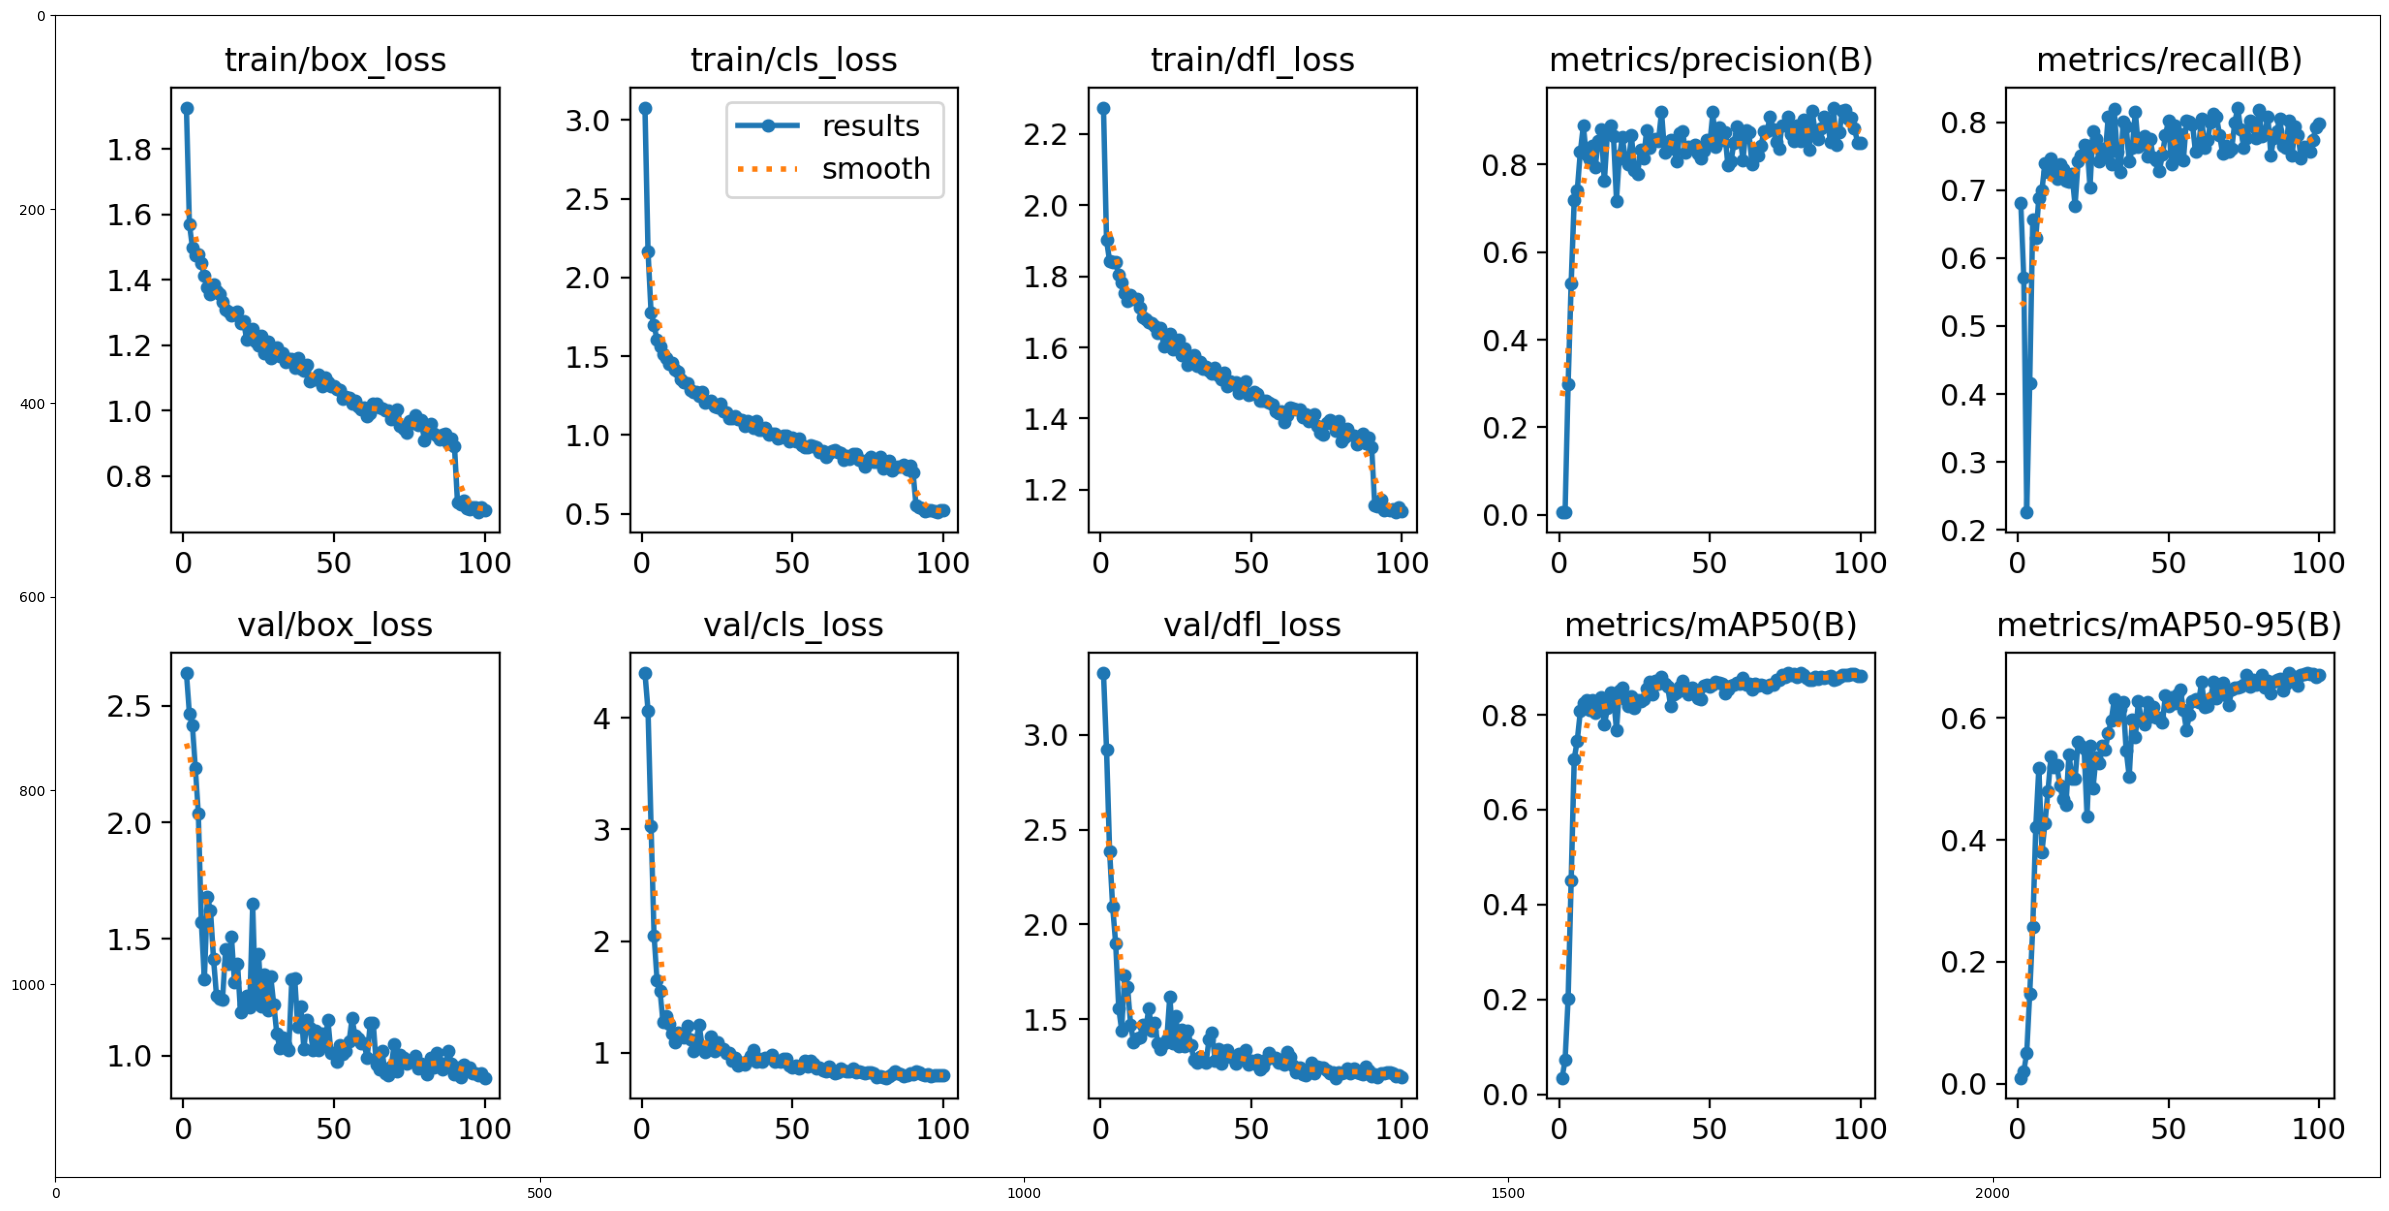

In [24]:
graphs(AUG_LOG_PATH)

### Training Losses (Top Row):
1. **train/box_loss**:  
   The bounding box regression loss during training shows a steady decrease over the epochs, indicating that the model's bounding box predictions are becoming more accurate as training progresses.

2. **train/cls_loss**:  
   The classification loss is also steadily decreasing, reflecting that the model is improving its ability to correctly classify objects.

3. **train/dfl_loss**:  
   The distribution focal loss (often used in advanced object detection models) follows a similar downward trend, demonstrating the model's improved capability in localizing objects with higher precision.

4. **metrics/precision(B)**:  
   Precision increases throughout the training, showing that the model is making fewer false positive predictions over time.

5. **metrics/recall(B)**:  
   Recall improves as well, reflecting the model's ability to detect more true positive instances, which implies it's becoming more sensitive to detecting objects.

### Validation Losses (Bottom Row):
6. **val/box_loss**:  
   The validation bounding box loss decreases with some fluctuations, which is normal during validation. It mirrors the downward trend seen in the training loss but with more noise.

7. **val/cls_loss**:  
   The validation classification loss also decreases but is slightly noisier than the training classification loss, as expected due to the variability in unseen validation data.

8. **val/dfl_loss**:  
   The validation distribution focal loss decreases similarly to the training loss, again with more noise, indicating the model generalizes well in localizing objects.

9. **metrics/mAP50(B)**:  
   The mean Average Precision (mAP) at IoU 0.50 steadily improves, demonstrating that the model's predictions are becoming more accurate in validation data, with high precision in correctly locating objects.

10. **metrics/mAP50-95(B)**:  
   This metric, which measures mAP across different IoU thresholds (from 0.50 to 0.95), also shows consistent improvement, indicating that the model's performance is improving not just at a fixed threshold but across varying levels of overlap between predicted and ground truth boxes.

### In summary:  
The model shows strong improvements across both training and validation losses. All the losses (box, classification, and distribution focal loss) consistently decrease, while key metrics such as precision, recall, and mAP show significant gains. Although validation losses exhibit more variability than training losses, the overall trends suggest the model is learning effectively and generalizing well to unseen data.

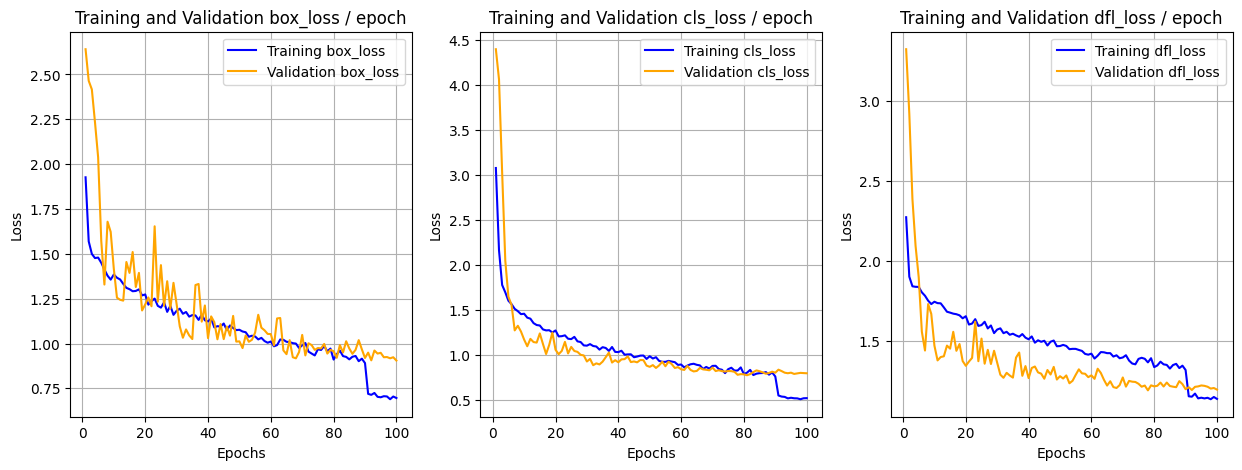

In [19]:
plot_results(results_path=aug_graphs_path)

### Analysis:

1. **Box Loss**:  
   The training box loss (blue line) demonstrates a consistent decrease across epochs, indicating steady improvement in bounding box predictions. In contrast, the validation box loss (orange line) also declines but exhibits more fluctuations, particularly in the initial epochs, reflecting variability in performance on the validation set. However, both trends converge around 60 epochs, aligning closely in loss values and suggesting effective generalization.

2. **Classification Loss**:  
   The training classification loss shows a pronounced decrease in the initial epochs, continuing to decline steadily and leveling off around 0.5. The validation classification loss mirrors this pattern, with slightly greater variability at the outset, but it stabilizes as training progresses. By the end of the training, the close alignment of training and validation losses indicates strong model performance without signs of overfitting.

3. **Distance Focal Loss**:  
   The training distribution focal loss steadily decreases, exhibiting a smoother trend compared to the validation loss. Initially higher and more variable, the validation focal loss shows a similar downward trajectory and stabilizes around 60 epochs, closely matching the training loss by the conclusion of the training process.

### Summary:
All losses—box, classification, and distribution focal loss—display a downward trend, indicating effective learning throughout training. The early fluctuations in validation losses are typical and diminish over time as the model better generalizes to unseen data. By the end of training, the validation losses closely align with the training losses, suggesting minimal overfitting and robust model generalization.

Overall, the model demonstrates a marked improvement with augmentations, effectively eliminating overfitting while achieving strong performance metrics.